# Pipelines

ce notebook sert pour tester le backend des pipelines

# Initialisation

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


## Imports Librairies

In [2]:
import os
from tqdm import tqdm
import glob
import numpy as np
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


"""import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
"""

KeyboardInterrupt: 

## Configs

### Variables Environnement

In [ ]:
root_dir = '../../data/raw/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/'

## Definitions

### Fonctions

In [ ]:
def load_paths_data_raw(root_dir):
    image_paths = []
    mask_paths = []
    labels = []

    for label in os.listdir(root_dir):
        class_img_dir = os.path.join(root_dir, label, 'images')
        class_mask_dir = os.path.join(root_dir, label, 'masks')
        if os.path.isdir(class_img_dir):
            for img_path in glob.glob(os.path.join(class_img_dir, '*.png')):
                filename = os.path.basename(img_path)
                mask_path = os.path.join(class_mask_dir, filename)
                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
                    labels.append(label.lower())

    return image_paths, mask_paths, labels

### Transformeurs

#### Image Loader

In [ ]:
# Transformer pour charger et prétraiter les images
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, img_size=(128, 128)):
        self.img_size = img_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"\nChargement de {len(X)} images...")
        images = []
        for path in tqdm(X, desc="Images"):
            img = Image.open(path).convert('L')  # PAS de resize ici
            images.append(img)
        print("Chargement terminé.\n")
        return images  # Liste d'images PIL

# Exemple d’utilisation
# Supposons que X contienne les chemins d’images et y les labels
# X = ['data/img1.png', 'data/img2.png', ...]
# y = [0, 1, 0, 1, ...]

#### Image Resizer

In [ ]:
class ImageResizer(BaseEstimator, TransformerMixin):
    """
    Redimensionne les images PIL ou numpy array à la taille souhaitée.
    """
    def __init__(self, img_size=(256, 256)):
        self.img_size = img_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"\nRedimensionnement de {len(X)} images en {self.img_size} ...")
        resized = []
        for img in tqdm(X, desc="Redimensionnement"):
            if isinstance(img, np.ndarray):
                img = Image.fromarray(img)
            img_resized = img.resize(self.img_size)
            resized.append(np.array(img_resized))
        print("Redimensionnement terminé.\n")
        return np.array(resized)


In [ ]:
class ImageAugmenter(BaseEstimator, TransformerMixin):
    """
    Applique une augmentation simple (flip horizontal) à la moitié des images.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        print(f"\nAugmentation de {len(X)} images (flip horizontal sur 50%) ...")
        X_aug = []
        for i, img in enumerate(X):
            if i % 2 == 0:
                X_aug.append(np.fliplr(img))
            else:
                X_aug.append(img)
        print("Augmentation terminée.\n")
        return np.array(X_aug)


In [ ]:
class ImageNormalizer(BaseEstimator, TransformerMixin):
    """
    Normalise les images (array) pixel-wise entre 0 et 1.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        print(f"\nNormalisation de {len(X)} images ...")
        X_norm = np.array(X).astype(np.float32) / 255.0
        print("Normalisation terminée.\n")
        return X_norm


#### Image Masker

In [ ]:
class ImageMasker(BaseEstimator, TransformerMixin):
    def __init__(self, mask_paths):
        self.mask_paths = mask_paths

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"\nApplication des masques sur {len(X)} images ...")
        masked = []
        for img, mask_path in tqdm(zip(X, self.mask_paths), desc="Masquage", total=len(X)):
            mask = Image.open(mask_path).convert('L').resize(img.shape[::-1])
            mask_arr = np.array(mask) > 0  # binaire
            masked.append(img * mask_arr)
        print("Masquage terminé.\n")
        return np.array(masked)


#### Image Flattener

In [ ]:
class ImageFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"\nAplatissement de {X.shape[0]} images ...")
        n_samples = X.shape[0]
        X_flat = []
        for img in tqdm(X, desc="Aplatissement"):
            X_flat.append(img.flatten())
        X_flat = np.array(X_flat)
        print("Aplatissement terminé.\n")
        return X_flat


In [ ]:
class VisualizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_samples=5, prefix="step", save_dir=None):
        self.n_samples = n_samples
        self.prefix = prefix
        self.save_dir = save_dir
        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for i in range(min(self.n_samples, len(X))):
            plt.figure()
            title = f"{self.prefix} - Sample {i} - shape={getattr(X[i], 'shape', None)}"
            if hasattr(X[i], "shape") and len(X[i].shape) == 2:
                plt.imshow(X[i], cmap='gray')
            elif hasattr(X[i], "shape") and len(X[i].shape) == 3:
                plt.imshow(X[i])
            else:
                plt.plot(X[i])
            plt.title(title)
            plt.axis('off')
            if self.save_dir:
                path = os.path.join(self.save_dir, f"{self.prefix}_sample_{i}.png")
                plt.savefig(path, bbox_inches='tight')
                print(f"Image sauvegardée : {path}")
            plt.show()
            plt.close()
        return X


In [ ]:
class SaveTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, save_dir="outputs", prefix="features"):
        self.save_dir = save_dir
        self.prefix = prefix
        os.makedirs(self.save_dir, exist_ok=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        path = os.path.join(self.save_dir, f"{self.prefix}.npy")
        np.save(path, X)
        print(f"Features sauvegardées dans {path}")
        return X


In [ ]:
class ImageHistogram(BaseEstimator, TransformerMixin):
    """
    Calcule l'histogramme d'intensité pour chaque image.
    """
    def __init__(self, bins=32):
        self.bins = bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        print(f"Calcul des histogrammes ({self.bins} bins)")
        histos = [np.histogram(img.flatten(), bins=self.bins, range=(0, 1))[0] for img in X]
        return np.array(histos)


In [ ]:
class ImageBinarizer(BaseEstimator, TransformerMixin):
    """
    Binarise les images (seuil fixe ou automatique).
    """
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        print(f"Binarisation avec seuil {self.threshold}")
        return (X > self.threshold).astype(np.float32)


In [ ]:
from sklearn.decomposition import PCA

class ImagePCA(BaseEstimator, TransformerMixin):
    """
    Réduction de dimension par ACP (PCA) sur les images aplaties.
    """
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
    def fit(self, X, y=None):
        n_samples = X.shape[0]
        X_flat = X.reshape(n_samples, -1)
        self.pca.fit(X_flat)
        return self
    def transform(self, X, y=None):
        n_samples = X.shape[0]
        X_flat = X.reshape(n_samples, -1)
        X_pca = self.pca.transform(X_flat)
        print(f"PCA terminé. Shape: {X_pca.shape}")
        return X_pca


In [ ]:
import random

class ImageRandomCropper(BaseEstimator, TransformerMixin):
    """
    Effectue un crop aléatoire sur chaque image (carré centré ou décalé).
    """
    def __init__(self, crop_size=(224, 224)):
        self.crop_size = crop_size
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        cropped = []
        for img in tqdm(X, desc="RandomCrop"):
            h, w = img.shape[:2]
            ch, cw = self.crop_size
            if h < ch or w < cw:
                cropped.append(img)
                continue
            top = random.randint(0, h - ch)
            left = random.randint(0, w - cw)
            cropped.append(img[top:top+ch, left:left+cw])
        print(f"Random crop terminé. Shape: {cropped[0].shape if cropped else None}")
        return np.array(cropped)


In [ ]:
from sklearn.preprocessing import StandardScaler

class ImageStandardScaler(BaseEstimator, TransformerMixin):
    """
    Applique un StandardScaler pixel-wise sur les images aplaties.
    """
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None):
        n_samples = X.shape[0]
        X_flat = X.reshape(n_samples, -1)
        self.scaler.fit(X_flat)
        return self
    def transform(self, X, y=None):
        n_samples = X.shape[0]
        X_flat = X.reshape(n_samples, -1)
        X_scaled = self.scaler.transform(X_flat)
        print(f"Standardisation terminée. Shape: {X_scaled.shape}")
        return X_scaled.reshape(X.shape)


# Main

## Chargement Paths

## Execution Pipeline

In [ ]:
X, masks, y = load_paths_data_raw(root_dir)

In [ ]:
print(f"Nombre d'images: {len(X)}")
print(f"Labels uniques: {set(y)}")


Nombre d'images: 21165
Labels uniques: {'lung_opacity', 'normal', 'covid', 'viral pneumonia'}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 16932, Test size: 4233


In [ ]:
def get_transformer_class(class_name):
    # Cherche la classe dans le scope global
    return globals()[class_name]

def load_pipeline_config(pipeline_file):
    """
    Charge la configuration d'un pipeline depuis un fichier JSON.
    """
    import json
    config_path = "../features/Pipelines/Configs_Pipelines/" + pipeline_file
    with open(config_path) as f:
        return json.load(f)

def create_pipeline_from_config(config, masks=None):
    """
    Crée un pipeline scikit-learn à partir d'une configuration JSON.
    Gère les pipelines simples et composites.
    """
    pipeline_type = config.get("type", "simple")
    
    if pipeline_type == "composite":
        return create_composite_pipeline(config, masks)
    else:
        return create_simple_pipeline(config, masks)

def create_simple_pipeline(config, masks=None):
    """
    Crée un pipeline simple à partir des étapes définies.
    """
    steps = []
    for step in config["steps"]:
        cls = get_transformer_class(step["class"])
        params = step["params"]
        if "mask_paths" in params and params["mask_paths"] == "masks" and masks is not None:
            params["mask_paths"] = masks
        steps.append((step["name"], cls(**params)))
    
    return Pipeline(steps, verbose=True)

def create_composite_pipeline(config, masks=None):
    """
    Crée un pipeline composite en combinant d'autres pipelines.
    """
    all_steps = []
    
    for step in config["steps"]:
        if step.get("type") == "pipeline":
            # Charger le sous-pipeline
            sub_config = load_pipeline_config(step["pipeline_file"])
            
            # Filtrer les étapes si nécessaire
            sub_steps = sub_config["steps"]
            if "include_steps" in step:
                sub_steps = [s for s in sub_steps if s["name"] in step["include_steps"]]
            elif "exclude_steps" in step:
                sub_steps = [s for s in sub_steps if s["name"] not in step["exclude_steps"]]
            
            # Ajouter les étapes du sous-pipeline
            for sub_step in sub_steps:
                cls = get_transformer_class(sub_step["class"])
                params = sub_step["params"]
                if "mask_paths" in params and params["mask_paths"] == "masks" and masks is not None:
                    params["mask_paths"] = masks
                all_steps.append((f"{step['name']}_{sub_step['name']}", cls(**params)))
        
        else:
            # Étape normale
            cls = get_transformer_class(step["class"])
            params = step["params"]
            if "mask_paths" in params and params["mask_paths"] == "masks" and masks is not None:
                params["mask_paths"] = masks
            all_steps.append((step["name"], cls(**params)))
    
    return Pipeline(all_steps, verbose=True)

# Chargement du registry des pipelines
registry_config = load_pipeline_config("pipeline_config.json")
print("Pipelines disponibles:")
print("=" * 50)

# Organiser par catégorie
categories = {}
for name, info in registry_config.items():
    # Ignorer les métadonnées
    if name in ["description"]:
        continue
    
    if isinstance(info, dict) and "category" in info:
        category = info.get("category", "other")
        if category not in categories:
            categories[category] = []
        categories[category].append((name, info))

# Afficher par catégorie
for category, pipelines in sorted(categories.items()):
    print(f"\nCatégorie: {category.upper()}")
    for name, info in pipelines:
        status = "(par défaut)" if name == "default" else ""
        print(f"  {name}: {info['description']} {status}")
        print(f"     Fichier: {info['file']}")

Pipelines disponibles:

Catégorie: COMPOSITE
  composite: Exemple de pipeline composite 
     Fichier: pipeline_composite_example.json

Catégorie: DATA_PROCESSING
  default: Pipeline simple et rapide (par défaut)
     Fichier: pipeline_simple.json
  simple: Pipeline simple et rapide 
     Fichier: pipeline_simple.json
  augmented: Pipeline avec augmentation et masquage 
     Fichier: pipeline_augmented.json

Catégorie: FEATURE_ENGINEERING
  feature_engineering: Pipeline avec feature engineering avancÃ© 
     Fichier: pipeline_feature_engineering.json


In [ ]:
def load_pipeline_by_name(pipeline_name, masks=None):
    """
    Charge un pipeline par son nom depuis le registry.
    """
    registry_config = load_pipeline_config("pipeline_config.json")
    
    # Filtrer les métadonnées
    available_pipelines = {k: v for k, v in registry_config.items() 
                          if isinstance(v, dict) and "file" in v}
    
    if pipeline_name not in available_pipelines:
        available = list(available_pipelines.keys())
        raise ValueError(f"Pipeline '{pipeline_name}' non trouvé. Disponibles: {available}")
    
    pipeline_file = available_pipelines[pipeline_name]["file"]
    pipeline_config = load_pipeline_config(pipeline_file)
    
    print(f"Chargement du pipeline: {pipeline_config['name']}")
    print(f"Description: {pipeline_config['description']}")
    
    return create_pipeline_from_config(pipeline_config, masks)

# Exemple d'utilisation :
# pipeline_simple = load_pipeline_by_name("simple", masks)
# pipeline_augmented = load_pipeline_by_name("augmented", masks)
# pipeline_composite = load_pipeline_by_name("composite", masks)

# Chargement du pipeline par défaut
default_pipeline_name = "default"  # Le pipeline par défaut est maintenant appelé "default"
default_config = load_pipeline_config(registry_config[default_pipeline_name]["file"])
pipeline = create_pipeline_from_config(default_config, masks)

print(f"\nPipeline par défaut chargé: {default_config['name']}")
print(f"Description: {default_config['description']}")
print(f"Nombre d'étapes: {len(pipeline.steps)}")


Pipeline par défaut chargé: pipeline_simple
Description: Pipeline simple pour classification rapide
Nombre d'étapes: 5


In [ ]:
# Test de chargement des différents pipelines
print("=" * 60)
print("TEST DES PIPELINES")
print("=" * 60)

try:
    # Test pipeline simple
    pipeline_simple = load_pipeline_by_name("simple", masks)
    print(f"✅ Pipeline simple: {len(pipeline_simple.steps)} étapes")
    
    # Test pipeline augmenté
    pipeline_augmented = load_pipeline_by_name("augmented", masks)
    print(f"✅ Pipeline augmenté: {len(pipeline_augmented.steps)} étapes")
    
    # Test pipeline feature engineering
    pipeline_fe = load_pipeline_by_name("feature_engineering", masks)
    print(f"✅ Pipeline feature engineering: {len(pipeline_fe.steps)} étapes")
    
    # Test pipeline composite
    pipeline_composite = load_pipeline_by_name("composite", masks)
    print(f"✅ Pipeline composite: {len(pipeline_composite.steps)} étapes")
    
    print("\n🎉 Tous les pipelines ont été chargés avec succès !")
    
except Exception as e:
    print(f"❌ Erreur lors du test: {e}")

TEST DES PIPELINES
Chargement du pipeline: pipeline_simple
Description: Pipeline simple pour classification rapide
✅ Pipeline simple: 5 étapes
Chargement du pipeline: pipeline_augmented
Description: Pipeline avec augmentation de donnÃ©es et masquage
✅ Pipeline augmenté: 8 étapes
Chargement du pipeline: pipeline_feature_engineering
Description: Pipeline avec feature engineering avancÃ© (histogrammes, PCA)
✅ Pipeline feature engineering: 8 étapes
Chargement du pipeline: pipeline_composite_example
Description: Pipeline composite utilisant d'autres pipelines comme sous-Ã©tapes
✅ Pipeline composite: 8 étapes

🎉 Tous les pipelines ont été chargés avec succès !



Chargement de 16932 images...


Images: 100%|██████████| 16932/16932 [02:12<00:00, 127.90it/s]


Chargement terminé.

[Pipeline]  (step 1 of 8) Processing preprocessing_img_loader, total= 2.2min

Redimensionnement de 16932 images en [256, 256] ...


Redimensionnement: 100%|██████████| 16932/16932 [00:09<00:00, 1874.35it/s]


Redimensionnement terminé.

[Pipeline]  (step 2 of 8) Processing preprocessing_img_resizer, total=   9.5s

Normalisation de 16932 images ...
Normalisation terminée.

[Pipeline]  (step 3 of 8) Processing preprocessing_img_normalizer, total=   3.2s

Aplatissement de 16932 images ...


Aplatissement: 100%|██████████| 16932/16932 [00:01<00:00, 11037.58it/s]


Aplatissement terminé.

[Pipeline]  (step 4 of 8) Processing preprocessing_img_flatten, total=   3.1s
Calcul des histogrammes (64 bins)
[Pipeline]  (step 5 of 8) Processing feature_engineering_img_histogram, total=   9.0s
PCA terminé. Shape: (16932, 50)
[Pipeline]  (step 6 of 8) Processing feature_engineering_img_pca, total=   0.0s
Image sauvegardée : outputs/composite\composite_sample_0.png


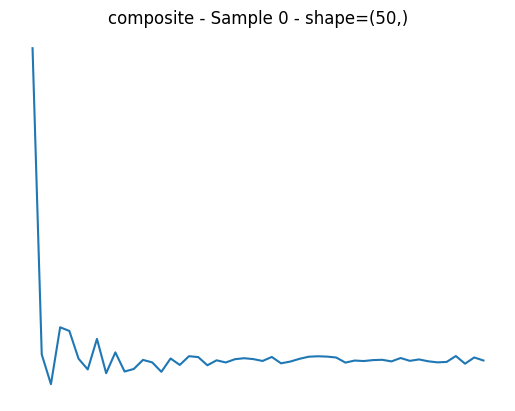

Image sauvegardée : outputs/composite\composite_sample_1.png


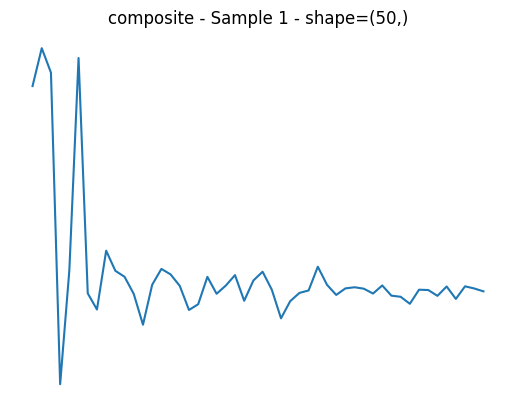

Image sauvegardée : outputs/composite\composite_sample_2.png


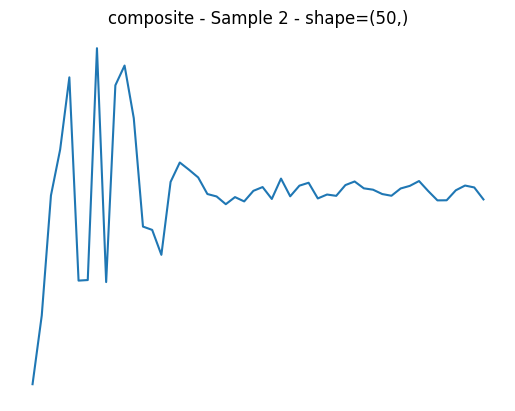

[Pipeline] ......... (step 7 of 8) Processing visualize, total=   0.3s


c:\Users\Léna\Documents\A_Repos\Data_Pipeline\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ............... (step 8 of 8) Processing clf, total=   1.0s

Chargement de 4233 images...


Images: 100%|██████████| 4233/4233 [00:33<00:00, 128.14it/s]


Chargement terminé.


Redimensionnement de 4233 images en [256, 256] ...


Redimensionnement: 100%|██████████| 4233/4233 [00:02<00:00, 1901.90it/s]


Redimensionnement terminé.


Normalisation de 4233 images ...
Normalisation terminée.


Aplatissement de 4233 images ...


Aplatissement: 100%|██████████| 4233/4233 [00:00<00:00, 10249.21it/s]


Aplatissement terminé.

Calcul des histogrammes (64 bins)
PCA terminé. Shape: (4233, 50)
Image sauvegardée : outputs/composite\composite_sample_0.png


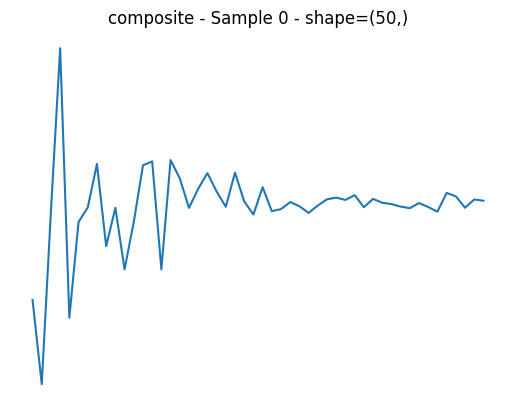

Image sauvegardée : outputs/composite\composite_sample_1.png


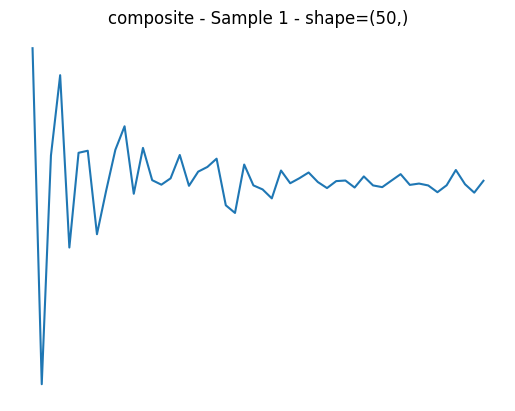

Image sauvegardée : outputs/composite\composite_sample_2.png


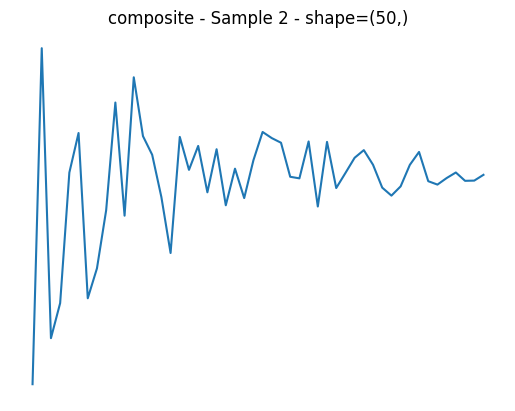


Chargement de 4233 images...


Images: 100%|██████████| 4233/4233 [00:04<00:00, 891.07it/s]


Chargement terminé.


Redimensionnement de 4233 images en [256, 256] ...


Redimensionnement: 100%|██████████| 4233/4233 [00:02<00:00, 1915.50it/s]


Redimensionnement terminé.


Normalisation de 4233 images ...
Normalisation terminée.


Aplatissement de 4233 images ...


Aplatissement: 100%|██████████| 4233/4233 [00:00<00:00, 9798.61it/s] 


Aplatissement terminé.

Calcul des histogrammes (64 bins)
PCA terminé. Shape: (4233, 50)
Image sauvegardée : outputs/composite\composite_sample_0.png


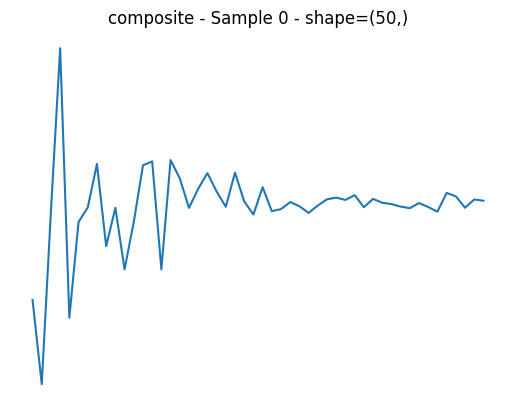

Image sauvegardée : outputs/composite\composite_sample_1.png


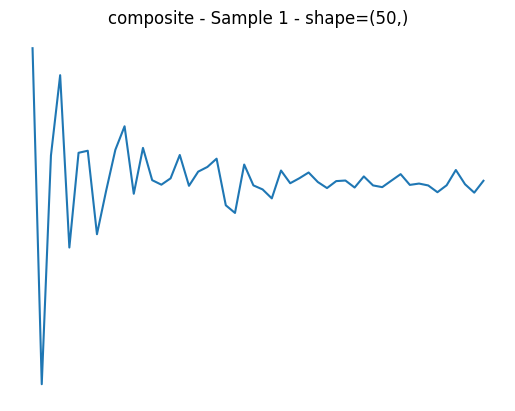

Image sauvegardée : outputs/composite\composite_sample_2.png


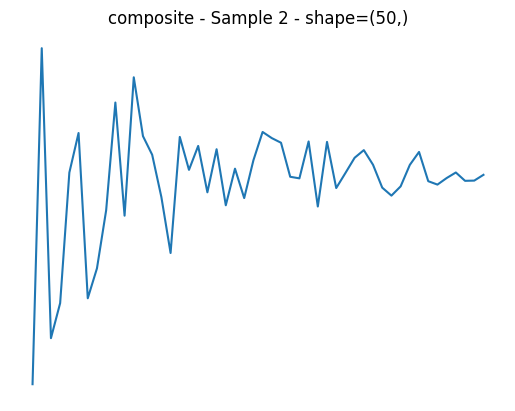

Accuracy: 0.5988660524450744

Classification report :
                 precision    recall  f1-score   support

          covid       0.62      0.49      0.55       701
   lung_opacity       0.57      0.44      0.49      1246
         normal       0.62      0.79      0.70      2024
viral pneumonia       0.36      0.20      0.26       262

       accuracy                           0.60      4233
      macro avg       0.54      0.48      0.50      4233
   weighted avg       0.59      0.60      0.58      4233


Matrice de confusion :
[[ 342   82  239   38]
 [  72  543  610   21]
 [ 110  280 1597   37]
 [  30   55  124   53]]


In [ ]:
#pipeline.fit(X_train, y_train)
pipeline_composite.fit(X_train, y_train)

# ... entraînement du pipeline ...
y_pred = pipeline_composite.predict(X_test)

print("Accuracy:", pipeline_composite.score(X_test, y_test))
print("\nClassification report :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))

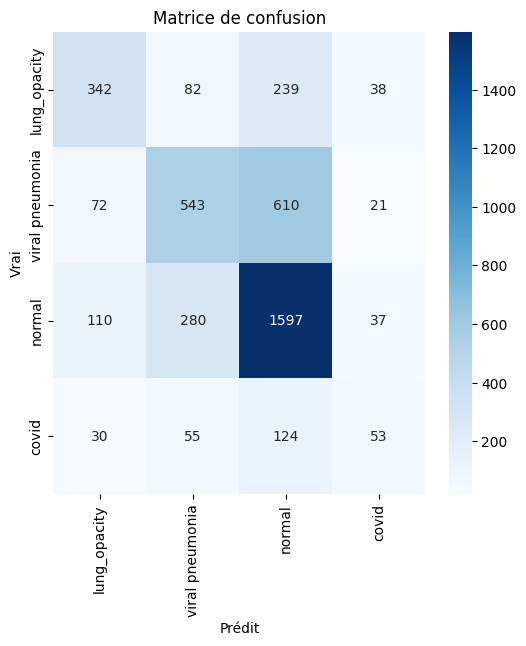

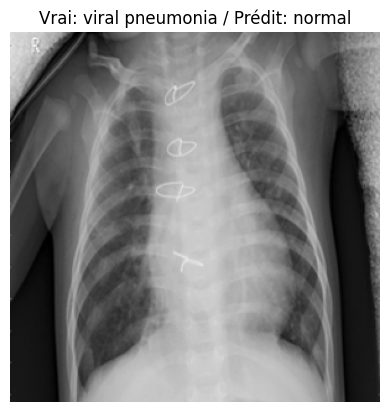

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion visuelle
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()

# Afficher quelques images test avec prédiction et vrai label
for i in range(1):
    img = Image.open(X_test[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"Vrai: {y_test[i]} / Prédit: {y_pred[i]}")
    plt.axis('off')
    plt.show()

In [ ]:
n_iter = pipeline_composite.named_steps["clf"].n_iter_
print(f"Nombre d'itérations effectuées par le classifieur : {n_iter[0]} (sur max_iter={pipeline_composite.named_steps['clf'].max_iter})")

Nombre d'itérations effectuées par le classifieur : 300 (sur max_iter=300)
